In [1]:
from utils import set_all_seed
np_gen, tr_gen = set_all_seed(42)

# Train Image Classificator

In [12]:
import os

import torch as tr
from torchvision import transforms, datasets

from visualization import show_batch
from torch_model_wrapper import TorchModelWrapper

In [ ]:
# initialize train, validation, test data
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

data = datasets.ImageFolder(os.path.join('data','dataset'),
                            transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize,
                            ]))
num_classes = len(data.classes)
num_samples = 10000
subset_idxs = np_gen.choice(len(data), size=num_samples, replace=False)
trn_idxs = subset_idxs[:int(num_samples*.4)]
trn_split = tr.utils.data.Subset(data, trn_idxs)
val_idxs = subset_idxs[int(num_samples*.4):int(num_samples*.7)]
val_split = tr.utils.data.Subset(data, val_idxs)
tst_idxs = subset_idxs[int(num_samples*.7):]
tst_split = tr.utils.data.Subset(data, tst_idxs)

len(data), len(trn_split), len(val_split), len(tst_split), num_classes

In [ ]:
trn_loader = tr.utils.data.DataLoader(trn_split, batch_size=50, shuffle=True, generator=tr_gen)
val_loader = tr.utils.data.DataLoader(val_split, batch_size=50, shuffle=True, generator=tr_gen)
tst_loader = tr.utils.data.DataLoader(tst_split, batch_size=50, shuffle=True, generator=tr_gen)
len(trn_loader), len(val_loader), len(tst_loader)

In [ ]:
show_batch(next(iter(trn_loader))[0][:10], transforms=transforms.Compose([normalize]))

In [ ]:
# initialize model
model_wrp = TorchModelWrapper(model_name='alexnet', num_classes=num_classes)
model_wrp

In [ ]:
# train model
model_wrp.train_model(trn_loader, val_loader, tst_loader,
                      num_epochs=3, device_idx=0, verbose=True)

In [ ]:
# store model
directory = os.path.join('data','models')
os.makedirs(directory, exist_ok=True)
model_wrp.store_model(directory)

# Train Adversarial Patches

In [1]:
import gdown
import zipfile

gdown.download(id='1S5l8Bn_oTckD5iiMSX82m9pxJp0762Qc')
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch as tr
from torchvision import transforms, datasets

from torch_model_wrapper import TorchModelWrapper
from adversarial_patch import AdversarialPatch

In [ ]:
# initialize train, validation, test data and exclude target class from patch training
target_class = ['book','cellphone','mouse','pencilcase','ringbinder'][1]

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data = datasets.ImageFolder(os.path.join('data','dataset'),
                            transform = transforms.Compose([
                                transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                #normalize,
                            ]))
num_classes = len(data.classes)
num_samples = 10000
subset_idxs = np_gen.choice(len(data), size=num_samples, replace=False)
val_idxs = [i for i in subset_idxs[int(num_samples*.4):int(num_samples*.7)] if data[i][1] != data.class_to_idx[target_class]]
val_split = tr.utils.data.Subset(data, val_idxs)
tst_idxs = subset_idxs[int(num_samples*.7):]
tst_split = tr.utils.data.Subset(data, tst_idxs)

len(val_split), len(tst_split), num_classes

In [ ]:
val_loader = tr.utils.data.DataLoader(val_split, batch_size=50, shuffle=True, generator=tr_gen)
tst_loader = tr.utils.data.DataLoader(tst_split, batch_size=50, shuffle=True, generator=tr_gen)

len(val_loader), len(tst_loader)

In [ ]:
# load trained model
model_wrp = TorchModelWrapper(model_name='alexnet', num_classes=num_classes)
model_wrp.load_model(os.path.join('data','models'))
model_wrp.set_model_gradients(False)

In [ ]:
# initialize adversarial patch with active gradients
patch = AdversarialPatch(input_shape = val_split[0][0].shape,
                         patch_type = "square", # "square" or "circle"
                         patch_position = 'centered', #'centered' or 'top_left'
                         patch_size = 50,
                         preprocess = [normalize],
                         optimize_location = True,
                         rotation_range = 45,
                         scale_range = (0.5, 1),
                         )

In [ ]:
from visualization import show_batch

x,_ = next(iter(val_loader))
for s in range(len(x)):
    x[s] = patch.apply_patch(x[s])
show_batch(x[:10], transforms=transforms.Compose([normalize]))

In [ ]:
adv_patch, succ_rate = patch.train(model_wrp.model, val_loader, tst_loader,
                                   target_class = data.class_to_idx[target_class],
                                   lr = 1.,
                                   num_epochs = 50,
                                   device_idx = 1,
                                   verbose = True)

In [ ]:
adv_patch = adv_patch.numpy().transpose(1,2,0)
adv_patch = (adv_patch*255).astype(np.uint8)
plt.imshow(adv_patch);

In [ ]:
# store patch
directory = os.path.join('data','patches')
os.makedirs(directory, exist_ok=True)
np.save(os.path.join(directory, f'{target_class}_{int(100*succ_rate)}.npy'), adv_patch)

# Webcam Testing

In [ ]:
import gdown
import zipfile

gdown.download(id='1S5l8Bn_oTckD5iiMSX82m9pxJp0762Qc')
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [2]:
import numpy as np
import os

from torch_model_wrapper import TorchModelWrapper
from run_webcam import webcam_inference
from visualization import show_patches

In [ ]:
# load trained model
model_wrp = TorchModelWrapper(model_name='alexnet', num_classes=num_classes)
model_wrp.load_model(os.path.join('data','models'))
model_wrp.set_model_gradients(False)

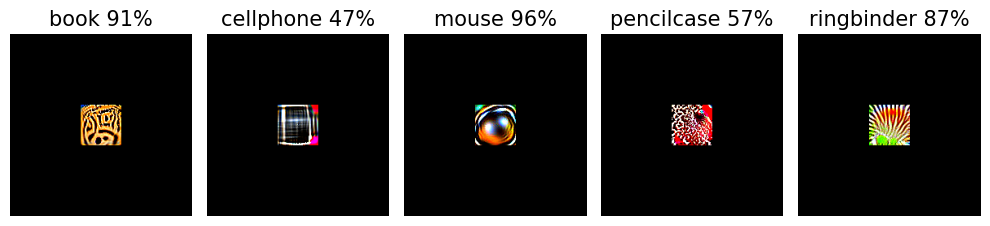

In [22]:
show_patches(['book_91', 'cellphone_47', 'mouse_96', 'pencilcase_57', 'ringbinder_87'])

In [ ]:
# load patch and run webcam test
name = ['book_91','cellphone_47','mouse_96','pencilcase_57','ringbinder_87'][4]
np_patch = np.load(os.path.join('data','patches', f"{name}_script.npy"))
webcam_inference(model_wrp.model, np_patch)